# Data Money Company 

The company Data Money provides Analysis and Data Science consulting services to large companies in Brazil and abroad.
Its main market differentiator in relation to competitors is the high financial return for client companies, thanks to the performance of its Machine Learning algorithms.
Data Money believes that the expertise in training and fine-tuning algorithms, carried out by the company's Data Scientists, is the main reason for the excellent results that the consultancies have been delivering to their clients.

To continue growing the team's expertise, Data Scientists believe that it is extremely important to carry out tests on Machine Learning algorithms to acquire more and more experience on how they work and in which scenarios the performances are maximum and minimum, so that the choice of algorithm for each situation is the most correct possible.

As a newly hired Data Scientist for the company, your main task will be to carry out 3 trials with Classification, Regression and Clustering algorithms, in order to extract insights into how they work in certain scenarios and be able to convey this knowledge to the rest of the team.

# 0 - Imports

In [16]:
import pandas            as pd
import numpy             as np
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import statsmodels.api   as sm

from sklearn.tree            import DecisionTreeRegressor
from sklearn.ensemble        import RandomForestRegressor
from sklearn.linear_model    import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.metrics         import (r2_score, mean_squared_error, root_mean_squared_error, mean_absolute_error, 
                                     mean_absolute_percentage_error)
from sklearn.preprocessing   import PolynomialFeatures
from sklearn.model_selection import GridSearchCV, ParameterGrid
from sklearn.pipeline        import Pipeline

import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings('ignore', category=UserWarning, module='numpy')

# 1 - Loading data

In [2]:
X_train = pd.read_csv('Data/Regression/X_training.csv')
y_train = pd.read_csv('Data/Regression/y_training.csv')

X_val   = pd.read_csv('Data/Regression/X_validation.csv')
y_val   = pd.read_csv('Data/Regression/y_val.csv')

X_test  = pd.read_csv('Data/Regression/X_test.csv')
y_test  = pd.read_csv('Data/Regression/y_test.csv')

# 2 - EDA

In [3]:
X_train.head()

,song_duration_ms,acousticness,danceability,energy,instrumentalness,key,liveness,loudness,audio_mode,speechiness,tempo,time_signature,audio_valence
0,0.205673,0.092100,0.720,0.802,0.000000,0.090909,0.694,0.431778,1,0.0582,0.103876,0.8,0.723
1,-0.240409,0.737000,0.483,0.412,0.000000,0.636364,0.116,-0.262732,1,0.0402,1.711532,0.6,0.247
2,-0.125770,0.274000,0.671,0.565,0.000065,1.000000,0.370,0.013612,0,0.1600,1.009176,0.8,0.561
3,-0.580967,0.002340,0.704,0.529,0.874000,1.000000,0.370,-0.266382,0,0.0416,0.666173,0.8,0.507
4,-0.688566,0.000414,0.354,0.910,0.205000,0.090909,0.456,0.422914,1,0.0430,1.182630,0.8,0.362


In [4]:
X_train.describe()

,song_duration_ms,acousticness,danceability,energy,instrumentalness,key,liveness,loudness,audio_mode,speechiness,tempo,time_signature,audio_valence
count,1.054700e+04,10547.000000,10547.000000,10547.000000,10547.000000,10547.000000,10547.000000,1.054700e+04,10547.000000,10547.000000,1.054700e+04,10547.000000,10547.000000
mean,5.995857e-17,0.259502,0.633974,0.645438,0.079089,0.483196,0.180416,2.489291e-16,0.627098,0.100937,-9.499054e-17,0.791581,0.529879
std,1.000047e+00,0.290173,0.156223,0.214348,0.222818,0.327242,0.144705,1.000047e+00,0.483599,0.103352,1.000047e+00,0.060822,0.244461
min,-3.553790e+00,0.000001,0.000000,0.001070,0.000000,0.000000,0.015700,-7.632256e+00,0.000000,0.000000,-4.220028e+00,0.000000,0.000000
25%,-5.810364e-01,0.024600,0.533000,0.512000,0.000000,0.181818,0.092700,-4.243671e-01,0.000000,0.037850,-7.756112e-01,0.800000,0.336000
50%,-1.146491e-01,0.132000,0.645000,0.675000,0.000011,0.454545,0.122000,2.346876e-01,1.000000,0.055200,-3.656695e-02,0.800000,0.532000
75%,4.224443e-01,0.432000,0.748000,0.815000,0.002835,0.727273,0.224000,6.609353e-01,1.000000,0.116000,6.566737e-01,0.800000,0.727000
max,1.969099e+01,0.996000,0.987000,0.999000,0.989000,1.000000,0.984000,2.292930e+00,1.000000,0.941000,4.226719e+00,1.000000,0.982000


In [5]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10547 entries, 0 to 10546
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   song_duration_ms  10547 non-null  float64
 1   acousticness      10547 non-null  float64
 2   danceability      10547 non-null  float64
 3   energy            10547 non-null  float64
 4   instrumentalness  10547 non-null  float64
 5   key               10547 non-null  float64
 6   liveness          10547 non-null  float64
 7   loudness          10547 non-null  float64
 8   audio_mode        10547 non-null  int64  
 9   speechiness       10547 non-null  float64
 10  tempo             10547 non-null  float64
 11  time_signature    10547 non-null  float64
 12  audio_valence     10547 non-null  float64
dtypes: float64(12), int64(1)
memory usage: 1.0 MB


In [6]:
y_train.head()

,song_popularity
0,79.0
1,86.0
2,63.0
3,25.0
4,35.0


# 3 - Model Training

In [3]:
def calculate_metrics(y_true, y_pred):
    """Calculate and return regression metrics """
    r2   =                             r2_score(y_true, y_pred)
    mse  =             float(mean_squared_error(y_true, y_pred))
    rmse =        float(root_mean_squared_error(y_true, y_pred))
    mae  =            float(mean_absolute_error(y_true, y_pred))
    mape = float(mean_absolute_percentage_error(y_true, y_pred))
    
    return {
        'R²': r2,
        'MSE': mse,
        'RMSE': rmse,
        'MAE': mae,
        'MAPE': mape
    }

X_train_val = np.concatenate((X_train, X_val))
y_train_val = np.concatenate((y_train, y_val))

## 3.1 -  Linear Regression

### 3.1.1 - Training

In [4]:
# Definition
lin_reg_model = LinearRegression()

# Training
lin_reg_model.fit(X_train, y_train)

# Performance
yhat_train = lin_reg_model.predict(X_train)
lin_reg_train_metrics = calculate_metrics(y_train, yhat_train)
lin_reg_train_metrics

{'R²': 0.04605830473391903,
 'MSE': 455.99611182562677,
 'RMSE': 21.35406546364478,
 'MAE': 16.998249066011095,
 'MAPE': 8.653185943804512}

Just for the sake of comparison, the regression was calculated using statsmodels to show the results in a different way

In [5]:
# Definition
model_lin_reg = sm.OLS(y_train, sm.add_constant(X_train))

# Training
results = model_lin_reg.fit()

print(results.summary())

                            OLS Regression Results                            
Dep. Variable:        song_popularity   R-squared:                       0.046
Model:                            OLS   Adj. R-squared:                  0.045
Method:                 Least Squares   F-statistic:                     39.12
Date:                Fri, 23 Aug 2024   Prob (F-statistic):           6.61e-98
Time:                        09:53:05   Log-Likelihood:                -47252.
No. Observations:               10547   AIC:                         9.453e+04
Df Residuals:                   10533   BIC:                         9.463e+04
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               53.5322      3.193  

### 3.1.2 - Validation

In [6]:
# Training
lin_reg_model.fit(X_train, y_train)

# Performance
yhat_val = lin_reg_model.predict(X_val)
lin_reg_val_metrics = calculate_metrics(y_val, yhat_val)
lin_reg_val_metrics

{'R²': 0.03992483038154071,
 'MSE': 458.4470418439312,
 'RMSE': 21.41137645841414,
 'MAE': 17.039753759960327,
 'MAPE': 8.682541883735295}

### 3.1.3 - Test

In [7]:
# Training
lin_reg_model.fit(X_train_val, y_train_val)

# Performance
yhat_test = lin_reg_model.predict(X_test)
lin_reg_test_metrics = calculate_metrics(y_test, yhat_test)
lin_reg_test_metrics

{'R²': 0.05116551777115064,
 'MSE': 461.9884353525593,
 'RMSE': 21.4939162404751,
 'MAE': 17.144197086987703,
 'MAPE': 8.531355027820084}

### 3.1.4 - Results

In [8]:
lin_reg_metrics = pd.DataFrame({
    'train': lin_reg_train_metrics,
    'val': lin_reg_val_metrics,
    'test': lin_reg_test_metrics
})

lin_reg_metrics = lin_reg_metrics.T
lin_reg_metrics

,R²,MSE,RMSE,MAE,MAPE
train,0.046058,455.996112,21.354065,16.998249,8.653186
val,0.039925,458.447042,21.411376,17.039754,8.682542
test,0.051166,461.988435,21.493916,17.144197,8.531355


## 3.2 -  Decision Tree Regressor

### 3.2.1 - Training

In [9]:
# Definition
dt_reg_model = DecisionTreeRegressor(random_state=0)

# Training
dt_reg_model.fit(X_train, y_train)

# Performance
yhat_train = dt_reg_model.predict(X_train)
dt_reg_train_metrics = calculate_metrics(y_train, yhat_train)
dt_reg_train_metrics

{'R²': 0.9917566957405923,
 'MSE': 3.940402971731975,
 'RMSE': 1.9850448286454327,
 'MAE': 0.21409852496986279,
 'MAPE': 0.08262787375974134}

### 3.2.2 - Validation

max_depth tested:  1  2  3  4  5  6  7  8  9  10  11  12  13  14  15  16  17  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  

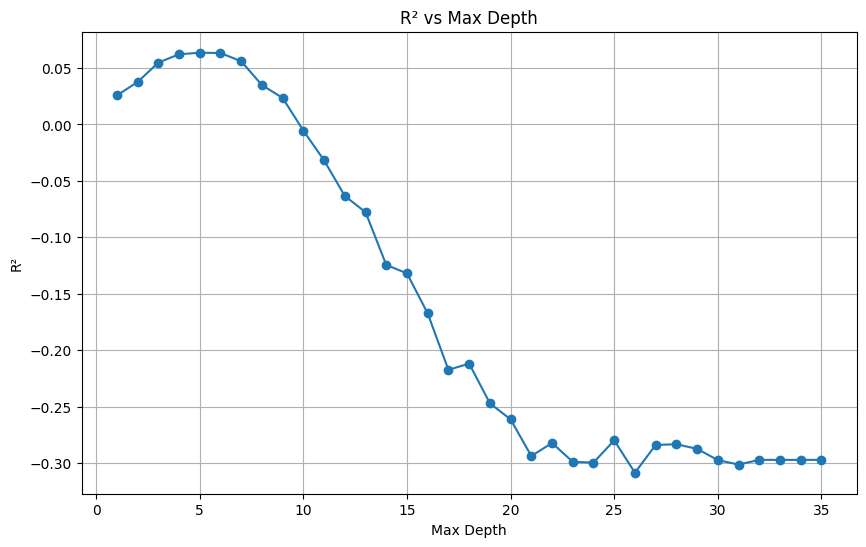

Best max_depth: 5
{'R²': 0.06355927779643322, 'MSE': 447.1613187611445, 'RMSE': 21.146189225511637, 'MAE': 16.843451865846713, 'MAPE': 8.395778483246199}


In [11]:
max_depth_range = range(1,36,1)
dt_reg_val_metrics = {i: None for i in max_depth_range}

print('max_depth tested:', end='  ')
for d in max_depth_range:

    # Definition
    dt_reg_model = DecisionTreeRegressor(random_state=0, max_depth=d)
    
    # Training
    dt_reg_model.fit(X_train, y_train)
    
    # Performance
    yhat_val = dt_reg_model.predict(X_val)
    dt_reg_val_metrics_d = calculate_metrics(y_val, yhat_val)
    dt_reg_val_metrics_d

    # Storing metrics in the dictionary
    dt_reg_val_metrics[d] = {
        'metrics': dt_reg_val_metrics_d
    }

    print(f'{d}', end='  ')

evaluated_metrics = [metrics['metrics']['R²'] for metrics in dt_reg_val_metrics.values()]

plt.figure(figsize=(10, 6))
plt.plot(max_depth_range, evaluated_metrics, marker='o')
plt.xlabel('Max Depth')
plt.ylabel('R²')
plt.title('R² vs Max Depth')
plt.grid(True)
plt.show()

dt_reg_best_max_depth = max(dt_reg_val_metrics, key=lambda k: dt_reg_val_metrics[k]['metrics']['R²'])
dt_reg_val_metrics = dt_reg_val_metrics[dt_reg_best_max_depth]['metrics']
print(f'Best max_depth: {dt_reg_best_max_depth}')
print(dt_reg_val_metrics)

### 3.2.3 - Test

In [12]:
# Definition
dt_reg_model = DecisionTreeRegressor(random_state=0, max_depth=dt_reg_best_max_depth)

# Training
dt_reg_model.fit(X_train_val, y_train_val)

# Performance
yhat_test = dt_reg_model.predict(X_test)
dt_reg_test_metrics = calculate_metrics(y_test, yhat_test)
dt_reg_test_metrics

{'R²': 0.09047547149696622,
 'MSE': 442.84838052138286,
 'RMSE': 21.043963042197703,
 'MAE': 16.82978094998882,
 'MAPE': 7.883226145162679}

### 3.2.4 - Results

In [13]:
dt_reg_metrics = pd.DataFrame({
    'train': dt_reg_train_metrics,
    'val': dt_reg_val_metrics,
    'test': dt_reg_test_metrics
})

dt_reg_metrics = dt_reg_metrics.T
dt_reg_metrics

,R²,MSE,RMSE,MAE,MAPE
train,0.991757,3.940403,1.985045,0.214099,0.082628
val,0.063559,447.161319,21.146189,16.843452,8.395778
test,0.090475,442.848381,21.043963,16.829781,7.883226


## 3.3 -  Random Forest Regressor

### 3.3.1 - Training

In [14]:
# Definition
rf_reg_model = RandomForestRegressor(random_state=0)

# Training
rf_reg_model.fit(X_train, y_train)

# Performance
yhat_train = rf_reg_model.predict(X_train)
rf_reg_train_metrics = calculate_metrics(y_train, yhat_train)
rf_reg_train_metrics

{'R²': 0.9028168842467658,
 'MSE': 46.45474994801846,
 'RMSE': 6.815772146134175,
 'MAE': 4.860772578122971,
 'MAPE': 2.5779585497476467}

### 3.3.2 - Validation

In [30]:
# Define the parameter grid
param_grid = {
    'n_estimators': range(400, 801, 200),
    'max_depth': range(33, 36, 1)
}

# Initialize variables to store the best results
rf_reg_best_score  = -float('inf')
rf_reg_best_params = None
rf_reg_best_model  = None

# Iterate over all combinations of parameters
for params in ParameterGrid(param_grid):
    # Create and train the model with the current parameters
    model = RandomForestRegressor(random_state=0, **params)
    model.fit(X_train, y_train)
    
    # Predict on the validation set
    yhat_val = model.predict(X_val)
    
    # Calculate the R² score
    score = r2_score(y_val, yhat_val)
    
    # Update the best score, parameters, and model if the current model is better
    if score > rf_reg_best_score:
        rf_reg_best_score  = score
        rf_reg_best_params = params
        rf_reg_best_model  = model

# Output the best parameters and metrics
print(f'\nBest parameters: {best_params}')

# Calculate and print metrics on the validation set using the best model
rf_reg_val_metrics = calculate_metrics(y_val, rf_reg_best_model.predict(X_val))
print('Metrics on the validation set:')
print(rf_reg_val_metrics)



Best parameters: {'max_depth': 34, 'n_estimators': 600}
Metrics on the validation set:
{'R²': 0.34104629968710454, 'MSE': 314.65804364111835, 'RMSE': 17.738603204342734, 'MAE': 12.930303888184845, 'MAPE': 7.033137554926378}


### 3.3.3 - Test

In [33]:
# Definition
rf_reg_model = RandomForestRegressor(random_state=0, 
                                     n_estimators=best_params['n_estimators'],
                                     max_depth=best_params['max_depth'])

# Training
rf_reg_model.fit(X_train_val, y_train_val)

# Performance
yhat_test = rf_reg_model.predict(X_test)
rf_reg_test_metrics = calculate_metrics(y_test, yhat_test)
rf_reg_test_metrics

{'R²': 0.407268371434819,
 'MSE': 288.6016083875375,
 'RMSE': 16.988278558686794,
 'MAE': 12.191283580226564,
 'MAPE': 6.317597012337652}

### 3.3.4 - Results

In [34]:
rf_reg_metrics = pd.DataFrame({
    'train': rf_reg_train_metrics,
    'val': rf_reg_val_metrics,
    'test': rf_reg_test_metrics
})

rf_reg_metrics = rf_reg_metrics.T
rf_reg_metrics

,R²,MSE,RMSE,MAE,MAPE
train,0.902817,46.454750,6.815772,4.860773,2.577959
val,0.341046,314.658044,17.738603,12.930304,7.033138
test,0.407268,288.601608,16.988279,12.191284,6.317597


## 3.4 -  Polynomial Regression

### 3.4.1 - Training

In [35]:
# Define polynomial model
poly = PolynomialFeatures()
X_poly_train = poly.fit_transform(X_train)

# Model Definition
pol_reg_model = LinearRegression()

# Training
pol_reg_model.fit(X_poly_train, y_train)

# Performance
yhat_train = pol_reg_model.predict(X_poly_train)

pol_reg_train_metrics = calculate_metrics(y_train, yhat_train)
pol_reg_train_metrics

{'R²': 0.09419491057528084,
 'MSE': 432.9862096386579,
 'RMSE': 20.80832068280999,
 'MAE': 16.458031755824443,
 'MAPE': 8.35053982092813}

### 3.4.2 - Validation

Degree tested:  1  2  3  

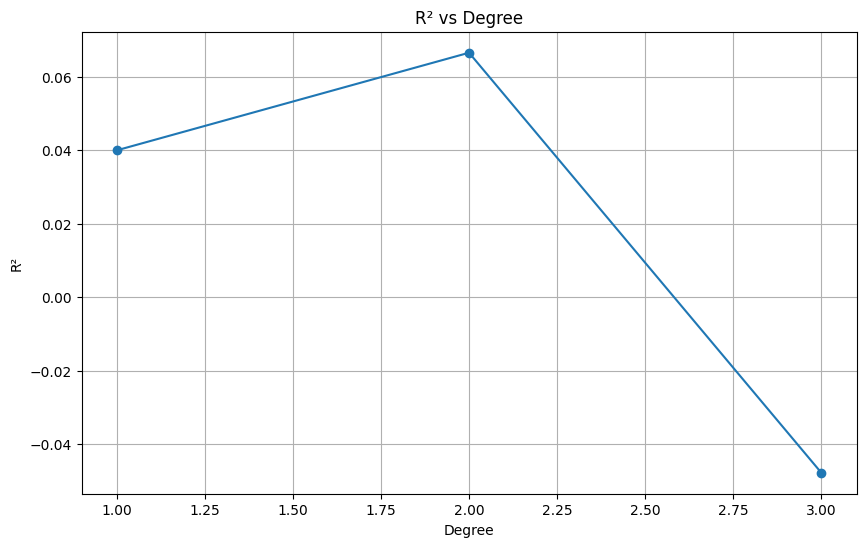

Best degree: 2
{'R²': 0.06647668389711614, 'MSE': 445.76822347127563, 'RMSE': 21.113223900467585, 'MAE': 16.749939090484034, 'MAPE': 8.54793103460539}


In [36]:
degree_range = range(1,4)
pol_reg_val_metrics = {i: None for i in degree_range}

print('Degree tested:', end='  ')
for d in degree_range:

    # Definition
    poly = PolynomialFeatures(degree=d)
    X_poly_train = poly.fit_transform(X_train)
    X_poly_val = poly.fit_transform(X_val)
    
    # Training
    pol_reg_model = LinearRegression()
    pol_reg_model.fit(X_poly_train, y_train)
    
    # Performance
    yhat_val = pol_reg_model.predict(X_poly_val)
    pol_reg_val_metrics_d = calculate_metrics(y_val, yhat_val)
    pol_reg_val_metrics_d

    # Storing metrics in the dictionary
    pol_reg_val_metrics[d] = {
        'metrics': pol_reg_val_metrics_d
    }
    
    print(f'{d}', end='  ')

evaluated_metrics = [metrics['metrics']['R²'] for metrics in pol_reg_val_metrics.values()]

plt.figure(figsize=(10, 6))
plt.plot(degree_range, evaluated_metrics, marker='o')
plt.xlabel('Degree')
plt.ylabel('R²')
plt.title('R² vs Degree')
plt.grid(True)
plt.show()

pol_reg_best_degree = max(pol_reg_val_metrics, key=lambda k: pol_reg_val_metrics[k]['metrics']['R²'])
pol_reg_val_metrics = pol_reg_val_metrics[pol_reg_best_degree]['metrics']
print(f'Best degree: {pol_reg_best_degree}')
print(pol_reg_val_metrics)

### 3.4.3 - Test

In [37]:
# Define polynomial model
poly = PolynomialFeatures(degree=pol_reg_best_degree)
X_poly_train_val = poly.fit_transform(X_train_val)

# Model Definition
pol_reg_model = LinearRegression()

# Training
pol_reg_model.fit(X_poly_train_val, y_train_val)

# Performance
yhat_test = pol_reg_model.predict(X_poly_train_val)

pol_reg_test_metrics = calculate_metrics(y_train_val, yhat_test)
pol_reg_test_metrics

{'R²': 0.08842233682193112,
 'MSE': 435.6086240978977,
 'RMSE': 20.87123916057448,
 'MAE': 16.539642685177714,
 'MAPE': 8.422772712904944}

### 3.4.4 - Results

In [38]:
pol_reg_metrics = pd.DataFrame({
    'train': pol_reg_train_metrics,
    'val': pol_reg_val_metrics,
    'test': pol_reg_test_metrics
})

pol_reg_metrics = pol_reg_metrics.T
pol_reg_metrics

,R²,MSE,RMSE,MAE,MAPE
train,0.094195,432.986210,20.808321,16.458032,8.350540
val,0.066477,445.768223,21.113224,16.749939,8.547931
test,0.088422,435.608624,20.871239,16.539643,8.422773


## 3.5 -  Linear Regression Lasso

### 3.5.1 - Training

In [39]:
# Definition
lasso = Lasso(random_state=0)

# Training
lasso.fit(X_train, y_train)

# Performance
yhat_train = lasso.predict(X_train)
lasso_train_metrics = calculate_metrics(y_train, yhat_train)
lasso_train_metrics

{'R²': 0.007400905609184383,
 'MSE': 474.47483414340275,
 'RMSE': 21.782443254681112,
 'MAE': 17.305483795260546,
 'MAPE': 8.736697313910927}

### 3.5.2 - Validation

In [49]:
alpha_range = np.arange(0, 2, 0.5)
max_iter_range = range(100, 501, 100)
lasso_val_metrics = {}

print('Testing combinations of alpha and max_iter:')
for alpha in alpha_range:
    for max_iter in max_iter_range:

        # Definição do modelo Lasso com os parâmetros alpha e max_iter
        lasso = Lasso(alpha=alpha, max_iter=max_iter, random_state=0)
        
        # Treinamento
        lasso.fit(X_train, y_train)
        
        # Desempenho

        yhat_val = lasso.predict(X_val)
        lasso_val_metrics[(alpha, max_iter)] = calculate_metrics(y_val, yhat_val)

        print(f'(alpha={alpha}, max_iter={max_iter})')

lasso_best_combination = max(lasso_val_metrics, key=lambda k: lasso_val_metrics[k]['R²'])

# Accessing the metrics of the best combination
lasso_val_metrics_best = lasso_val_metrics[lasso_best_combination]

# Displaying the best combination and its metrics
print(f'\nBest Combination (alpha, max_iter): {lasso_best_combination}')
print(lasso_val_metrics_best)

Testing combinations of alpha and max_iter:
(alpha=0.0, max_iter=100)
(alpha=0.0, max_iter=200)
(alpha=0.0, max_iter=300)
(alpha=0.0, max_iter=400)
(alpha=0.0, max_iter=500)
(alpha=0.5, max_iter=100)
(alpha=0.5, max_iter=200)
(alpha=0.5, max_iter=300)
(alpha=0.5, max_iter=400)
(alpha=0.5, max_iter=500)
(alpha=1.0, max_iter=100)
(alpha=1.0, max_iter=200)
(alpha=1.0, max_iter=300)
(alpha=1.0, max_iter=400)
(alpha=1.0, max_iter=500)
(alpha=1.5, max_iter=100)
(alpha=1.5, max_iter=200)
(alpha=1.5, max_iter=300)
(alpha=1.5, max_iter=400)
(alpha=1.5, max_iter=500)

Best Combination (alpha, max_iter): (np.float64(0.0), 200)
{'R²': 0.03992483038154071, 'MSE': 458.4470418439312, 'RMSE': 21.41137645841414, 'MAE': 17.039753759960327, 'MAPE': 8.682541883735295}


### 3.5.3 - Test

In [43]:
# Definition
lasso = Lasso(random_state=0,
              alpha=lasso_best_combination[0],
              max_iter=lasso_best_combination[1])

# Training
lasso.fit(X_train_val, y_train_val)

# Performance
yhat_test = lasso.predict(X_test)
lasso_test_metrics = calculate_metrics(y_test, yhat_test)
lasso_test_metrics

{'R²': 0.05116551777115064,
 'MSE': 461.9884353525593,
 'RMSE': 21.4939162404751,
 'MAE': 17.144197086987703,
 'MAPE': 8.531355027820084}

### 3.5.4 - Results

In [44]:
lasso_metrics = pd.DataFrame({
    'train': lasso_train_metrics,
    'val': lasso_val_metrics_best,
    'test': lasso_test_metrics
})

lasso_metrics = lasso_metrics.T
lasso_metrics

,R²,MSE,RMSE,MAE,MAPE
train,0.007401,474.474834,21.782443,17.305484,8.736697
val,0.039925,458.447042,21.411376,17.039754,8.682542
test,0.051166,461.988435,21.493916,17.144197,8.531355


## 3.6 -  Linear Regression Ridge

### 3.6.1 - Training

In [45]:
# Definition
ridge = Ridge(random_state=0)

# Training
ridge.fit(X_train, y_train)

# Performance
yhat_train = ridge.predict(X_train)
ridge_train_metrics = calculate_metrics(y_train, yhat_train)
ridge_train_metrics

{'R²': 0.04605770063554282,
 'MSE': 455.99640059223805,
 'RMSE': 21.354072225040312,
 'MAE': 16.9983076023201,
 'MAPE': 8.653414734181558}

### 3.6.2 - Validation

In [48]:
alpha_range = np.arange(0, 2, 0.5)
max_iter_range = range(100, 501, 100)
ridge_val_metrics = {}

print('Testing combinations of alpha and max_iter:')
for alpha in alpha_range:
    for max_iter in max_iter_range:

        # Definição do modelo ridge com os parâmetros alpha e max_iter
        ridge = Ridge(alpha=alpha, max_iter=max_iter, random_state=0)
        
        # Treinamento
        ridge.fit(X_train, y_train)
        
        # Desempenho
        yhat_val = ridge.predict(X_val)
        ridge_val_metrics[(alpha, max_iter)] = calculate_metrics(y_val, yhat_val)

        print(f'(alpha={alpha}, max_iter={max_iter})')

ridge_best_combination = max(ridge_val_metrics, key=lambda k: ridge_val_metrics[k]['R²'])

# Accessing the metrics of the best combination
ridge_val_metrics_best = ridge_val_metrics[ridge_best_combination]

# Displaying the best combination and its metrics
print(f'\nBest Combination (alpha, max_iter): {ridge_best_combination}')
print(ridge_val_metrics_best)

Testing combinations of alpha and max_iter:
(alpha=0.0, max_iter=100)
(alpha=0.0, max_iter=200)
(alpha=0.0, max_iter=300)
(alpha=0.0, max_iter=400)
(alpha=0.0, max_iter=500)
(alpha=0.5, max_iter=100)
(alpha=0.5, max_iter=200)
(alpha=0.5, max_iter=300)
(alpha=0.5, max_iter=400)
(alpha=0.5, max_iter=500)
(alpha=1.0, max_iter=100)
(alpha=1.0, max_iter=200)
(alpha=1.0, max_iter=300)
(alpha=1.0, max_iter=400)
(alpha=1.0, max_iter=500)
(alpha=1.5, max_iter=100)
(alpha=1.5, max_iter=200)
(alpha=1.5, max_iter=300)
(alpha=1.5, max_iter=400)
(alpha=1.5, max_iter=500)

Best Combination (alpha, max_iter): (np.float64(1.5), 100)
{'R²': 0.03992955619248495, 'MSE': 458.4447852143294, 'RMSE': 21.411323761372845, 'MAE': 17.039331077459902, 'MAPE': 8.682348600505266}


### 3.6.3 - Test

In [50]:
# Definition
ridge = Ridge(random_state=0,
              alpha=ridge_best_combination[0],
              max_iter=ridge_best_combination[1])

# Training
ridge.fit(X_train_val, y_train_val)

# Performance
yhat_test = ridge.predict(X_test)
ridge_test_metrics = calculate_metrics(y_test, yhat_test)
ridge_test_metrics

{'R²': 0.051167062631854,
 'MSE': 461.98768315837515,
 'RMSE': 21.49389874262869,
 'MAE': 17.143837970013415,
 'MAPE': 8.532387164061522}

### 3.6.4 - Results

In [51]:
ridge_metrics = pd.DataFrame({
    'train': ridge_train_metrics,
    'val': ridge_val_metrics_best,
    'test': ridge_test_metrics
})

ridge_metrics = ridge_metrics.T
ridge_metrics

,R²,MSE,RMSE,MAE,MAPE
train,0.046058,455.996401,21.354072,16.998308,8.653415
val,0.039930,458.444785,21.411324,17.039331,8.682349
test,0.051167,461.987683,21.493899,17.143838,8.532387


## 3.7 -  Linear Regression ElasticNet

### 3.7.1 - Training

In [52]:
# Definition
elasticnet = ElasticNet(random_state=0)

# Training
elasticnet.fit(X_train, y_train)

# Performance
yhat_train = elasticnet.predict(X_train)
elasticnet_train_metrics = calculate_metrics(y_train, yhat_train)
elasticnet_train_metrics

{'R²': 0.007831741118630053,
 'MSE': 474.2688893586024,
 'RMSE': 21.777715430196125,
 'MAE': 17.299506969671594,
 'MAPE': 8.732300419042266}

### 3.7.2 - Validation

In [53]:
# Defining the parameter ranges
alpha_range = np.arange(0, 1.1, 0.1)
l1_ratio_range = np.arange(0, 1.1, 0.1)
max_iter_range = range(100, 501, 100)

# Creating the parameter grid for GridSearchCV
param_grid = {
    'alpha': alpha_range,
    'l1_ratio': l1_ratio_range,
    'max_iter': max_iter_range
}

# Defining the ElasticNet model
elasticnet = ElasticNet(random_state=0)

# Setting up GridSearchCV
grid_search = GridSearchCV(estimator=elasticnet, param_grid=param_grid, scoring='r2', cv=5)

# Training the model
grid_search.fit(X_train, y_train)

# Prediction and evaluation on the validation set
yhat_val = grid_search.best_estimator_.predict(X_val)

# Storing the best metrics
elasticnet_best_params = grid_search.best_params_
# elasticnet_best_score = grid_search.best_score_

# Displaying the best parameter combination and the best metric
print(f'Best combination (alpha, l1_ratio, max_iter): {elasticnet_best_params}')

# Calculating metrics for the validation set using the best model
best_elasticnet = grid_search.best_estimator_
elasticnet_val_metrics_best = calculate_metrics(y_val, yhat_val)

print('\nMetrics on the validation set:')
elasticnet_val_metrics_best

Best combination (alpha, l1_ratio, max_iter): {'alpha': np.float64(0.0), 'l1_ratio': np.float64(0.0), 'max_iter': 400}

Metrics on the validation set:


{'R²': 0.03992483038154071,
 'MSE': 458.4470418439312,
 'RMSE': 21.41137645841414,
 'MAE': 17.039753759960327,
 'MAPE': 8.682541883735295}

### 3.5.3 - Test

In [54]:
# Definition
elasticnet = ElasticNet(random_state=0,
                        alpha=elasticnet_best_params['alpha'],
                        max_iter=elasticnet_best_params['max_iter'],
                        l1_ratio=elasticnet_best_params['l1_ratio'])

# Training
elasticnet.fit(X_train_val, y_train_val)

# Performance
yhat_test = elasticnet.predict(X_test)
elasticnet_test_metrics = calculate_metrics(y_test, yhat_test)
elasticnet_test_metrics

{'R²': 0.05116551777115064,
 'MSE': 461.9884353525593,
 'RMSE': 21.4939162404751,
 'MAE': 17.144197086987703,
 'MAPE': 8.531355027820084}

### 3.7.4 - Results

In [55]:
elasticnet_metrics = pd.DataFrame({
    'train': elasticnet_train_metrics,
    'val': elasticnet_val_metrics_best,
    'test': elasticnet_test_metrics
})

elasticnet_metrics = elasticnet_metrics.T
elasticnet_metrics

,R²,MSE,RMSE,MAE,MAPE
train,0.007832,474.268889,21.777715,17.299507,8.732300
val,0.039925,458.447042,21.411376,17.039754,8.682542
test,0.051166,461.988435,21.493916,17.144197,8.531355


## 3.8 - Polynomial Regression Lasso

### 3.8.1 - Training

In [56]:
# Define polynomial model
poly = PolynomialFeatures()
X_poly_train = poly.fit_transform(X_train)

# Model Definition
poly_lasso = Lasso()

# Training
poly_lasso.fit(X_poly_train, y_train)

# Performance
yhat_train = poly_lasso.predict(X_poly_train)

poly_lasso_train_metrics = calculate_metrics(y_train, yhat_train)
poly_lasso_train_metrics

{'R²': 0.009149935251170582,
 'MSE': 473.6387760067563,
 'RMSE': 21.763243692215468,
 'MAE': 17.285449661261286,
 'MAPE': 8.699700898061744}

### 3.8.2 - Validation

In [58]:
# Define the parameter grid
param_grid = {
    'poly__degree': [1,2,3],  # Polynomial degree
    'lasso__alpha': [0, 0.1, 0.2, 0.3],  # Lasso alpha
    'lasso__max_iter': [100, 200, 300]  # Lasso max_iter
}

# Create the pipeline
pipeline = Pipeline([
    ('poly', PolynomialFeatures()),  # Polynomial features
    ('lasso', Lasso())  # Lasso regression
])

# Set up GridSearchCV
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='r2')

# Fit GridSearchCV
grid_search.fit(X_train, y_train)

# Extract the best parameters and metrics
poly_lasso_rf_best_params_val = grid_search.best_params_
poly_lasso_rf_best_score_val  = grid_search.best_score_
poly_lasso_rf_best_model_val  = grid_search.best_estimator_

# poly_lasso_rf_best_params_val

print(f'\nBest parameters: {best_params}')

# Use the best model to predict on the validation set
yhat_val = best_model.predict(X_val)

# Calculate and print metrics on the validation set
poly_lasso_val_metrics = calculate_metrics(y_val, yhat_val)
print('Metrics on the validation set:')
poly_lasso_val_metrics


Best parameters: {'max_depth': 34, 'n_estimators': 600}


[Parallel(n_jobs=1)]: Done  31 tasks      | elapsed:    4.2s
[Parallel(n_jobs=1)]: Done 127 tasks      | elapsed:   35.2s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:  1.1min
[Parallel(n_jobs=1)]: Done 511 tasks      | elapsed:  1.2min


Metrics on the validation set:


{'R²': 0.34104629968710454,
 'MSE': 314.65804364111835,
 'RMSE': 17.738603204342734,
 'MAE': 12.930303888184845,
 'MAPE': 7.033137554926378}

### 3.8.3 - Test

In [59]:
# Define polynomial model
poly = PolynomialFeatures(degree=poly_lasso_rf_best_params_val['poly__degree'])
X_poly_train_val = poly.fit_transform(X_train_val)

# Model Definition
poly_lasso = Lasso(
    random_state=0,
    alpha=poly_lasso_rf_best_params_val['lasso__alpha'],
    max_iter=poly_lasso_rf_best_params_val['lasso__max_iter']
)

# Training
poly_lasso.fit(X_poly_train_val, y_train_val)

# Performance
yhat_test = poly_lasso.predict(X_poly_train_val)

poly_lasso_test_metrics = calculate_metrics(y_train_val, yhat_test)
poly_lasso_test_metrics

{'R²': 0.0872685664411691,
 'MSE': 436.15996749779674,
 'RMSE': 20.884443193386716,
 'MAE': 16.551554223838984,
 'MAPE': 8.438346577036386}

### 3.8.4 - Results

In [60]:
poly_lasso_metrics = pd.DataFrame({
    'train': poly_lasso_train_metrics,
    'val': poly_lasso_val_metrics,
    'test': poly_lasso_test_metrics
})

poly_lasso_metrics = poly_lasso_metrics.T
poly_lasso_metrics

,R²,MSE,RMSE,MAE,MAPE
train,0.009150,473.638776,21.763244,17.285450,8.699701
val,0.341046,314.658044,17.738603,12.930304,7.033138
test,0.087269,436.159967,20.884443,16.551554,8.438347


## 3.9 - Polynomial Regression Ridge

### 3.9.1 - Training

In [61]:
# Define polynomial model
poly = PolynomialFeatures()
X_poly_train = poly.fit_transform(X_train)

# Model Definition
poly_ridge = Ridge()

# Training
poly_ridge.fit(X_poly_train, y_train)

# Performance
yhat_train = poly_ridge.predict(X_poly_train)

poly_ridge_train_metrics = calculate_metrics(y_train, yhat_train)
poly_ridge_train_metrics

{'R²': 0.09317140761274356,
 'MSE': 433.47545690992735,
 'RMSE': 20.820073412693034,
 'MAE': 16.471971837686485,
 'MAPE': 8.372689165744584}

### 3.9.2 - Validation

In [63]:
# Define the parameter grid
param_grid = {
    'poly__degree': [1,2,3],  # Polynomial degree
    'ridge__alpha': [0, 0.1, 0.2, 0.3],  # Ridge alpha
    'ridge__max_iter': [100, 200, 300]  # Ridge max_iter
}

# Create the pipeline
pipeline = Pipeline([
    ('poly', PolynomialFeatures()),  # Polynomial features
    ('ridge', Ridge())  # Ridge regression
])

# Set up GridSearchCV
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='r2')

# Fit GridSearchCV
grid_search.fit(X_train, y_train)

# Extract the best parameters and metrics
poly_ridge_rf_best_params_val = grid_search.best_params_
poly_ridge_rf_best_score_val  = grid_search.best_score_
poly_ridge_rf_best_model_val  = grid_search.best_estimator_

print(f'\nBest parameters: {best_params}')

# Use the best model to predict on the validation set
yhat_val = best_model.predict(X_val)

# Calculate and print metrics on the validation set
poly_ridge_val_metrics = calculate_metrics(y_val, yhat_val)
print('Metrics on the validation set:')
poly_ridge_val_metrics


Best parameters: {'max_depth': 34, 'n_estimators': 600}


[Parallel(n_jobs=1)]: Done  31 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 127 tasks      | elapsed:    2.2s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    3.4s
[Parallel(n_jobs=1)]: Done 511 tasks      | elapsed:    5.1s


Metrics on the validation set:


{'R²': 0.34104629968710454,
 'MSE': 314.65804364111835,
 'RMSE': 17.738603204342734,
 'MAE': 12.930303888184845,
 'MAPE': 7.033137554926378}

### 3.9.3 - Test

In [64]:
# Define polynomial model
poly = PolynomialFeatures(degree=poly_ridge_rf_best_params_val['poly__degree'])
X_poly_train_val = poly.fit_transform(X_train_val)

# Model Definition
poly_ridge = Ridge(
    random_state=0,
    alpha=poly_ridge_rf_best_params_val['ridge__alpha'],
    max_iter=poly_ridge_rf_best_params_val['ridge__max_iter']
)

# Training
poly_ridge.fit(X_poly_train_val, y_train_val)

# Performance
yhat_test = poly_ridge.predict(X_poly_train_val)

poly_ridge_test_metrics = calculate_metrics(y_train_val, yhat_test)
poly_ridge_test_metrics

{'R²': 0.08828193754812452,
 'MSE': 435.6757156217005,
 'RMSE': 20.87284637086424,
 'MAE': 16.541496752693874,
 'MAPE': 8.428237504187727}

### 3.9.4 - Results

In [65]:
poly_ridge_metrics = pd.DataFrame({
    'train': poly_ridge_train_metrics,
    'val': poly_ridge_val_metrics,
    'test': poly_ridge_test_metrics
})

poly_ridge_metrics = poly_ridge_metrics.T
poly_ridge_metrics

,R²,MSE,RMSE,MAE,MAPE
train,0.093171,433.475457,20.820073,16.471972,8.372689
val,0.341046,314.658044,17.738603,12.930304,7.033138
test,0.088282,435.675716,20.872846,16.541497,8.428238


## 3.10 - Polynomial Regression ElasticNet

### 3.10.1 - Training

In [66]:
# Define polynomial model
poly = PolynomialFeatures()
X_poly_train = poly.fit_transform(X_train)

# Model Definition
poly_elasticnet = ElasticNet()

# Training
poly_elasticnet.fit(X_poly_train, y_train)

# Performance
yhat_train = poly_elasticnet.predict(X_poly_train)

poly_elasticnet_train_metrics = calculate_metrics(y_train, yhat_train)
poly_elasticnet_train_metrics

{'R²': 0.012832763427018778,
 'MSE': 471.8783378824533,
 'RMSE': 21.722760825513255,
 'MAE': 17.244236014680347,
 'MAPE': 8.678785850035073}

### 3.10.2 - Validation

In [69]:
# Define the parameter grid
param_grid = {
    'poly__degree': [1, 2, 3],  # Polynomial degree
    'elasticnet__alpha': [0.1, 0.5, 1.0],  # ElasticNet alpha
    'elasticnet__l1_ratio': [0.2, 0.5, 0.8],  # ElasticNet l1_ratio
    'elasticnet__max_iter': [100, 200, 300]  # ElasticNet max_iter
}

# Create the pipeline
pipeline = Pipeline([
    ('poly', PolynomialFeatures()),  # Polynomial features
    ('elasticnet', ElasticNet())  # ElasticNet regression
])

# Set up GridSearchCV
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='r2')

# Fit GridSearchCV
grid_search.fit(X_train, y_train)

# Extract the best parameters and metrics
poly_elasticnet_best_params_val = grid_search.best_params_
poly_elasticnet_best_score_val  = grid_search.best_score_
poly_elasticnet_best_model_val  = grid_search.best_estimator_

print(f'\nBest parameters: {poly_elasticnet_best_params_val}')

# Use the best model to predict on the validation set
yhat_val = poly_elasticnet_best_model_val.predict(X_val)

# Calculate and print metrics on the validation set
poly_elasticnet_val_metrics = calculate_metrics(y_val, yhat_val)
print('Metrics on the validation set:')
poly_elasticnet_val_metrics


Best parameters: {'elasticnet__alpha': 0.1, 'elasticnet__l1_ratio': 0.8, 'elasticnet__max_iter': 100, 'poly__degree': 2}
Metrics on the validation set:


{'R²': 0.05613123540308984,
 'MSE': 450.7082952580712,
 'RMSE': 21.2298915507845,
 'MAE': 16.831713756659383,
 'MAPE': 8.65523713222475}

### 3.10.3 - Test

In [72]:
# Define polynomial model
poly = PolynomialFeatures(degree=poly_elasticnet_best_params_val['poly__degree'])
X_poly_train_val = poly.fit_transform(X_train_val)

# Model Definition
poly_elasticnet = ElasticNet(
    random_state=0,
    alpha=poly_elasticnet_best_params_val['elasticnet__alpha'],
    l1_ratio=poly_elasticnet_best_params_val['elasticnet__l1_ratio'],
    max_iter=poly_elasticnet_best_params_val['elasticnet__max_iter']
)

# Training
poly_elasticnet.fit(X_poly_train_val, y_train_val)

# Performance
yhat_test = poly_elasticnet.predict(X_poly_train_val)

# Calculate and store metrics for the test set
poly_elasticnet_test_metrics = calculate_metrics(y_train_val, yhat_test)
poly_elasticnet_test_metrics

{'R²': 0.06127463023377222,
 'MSE': 448.58149036258067,
 'RMSE': 21.17974245269712,
 'MAE': 16.802161479317814,
 'MAPE': 8.58271307973785}

### 3.10.4 - Results

In [73]:
poly_elasticnet_metrics = pd.DataFrame({
    'train': poly_elasticnet_train_metrics,
    'val': poly_elasticnet_val_metrics,
    'test': poly_elasticnet_test_metrics
})

poly_elasticnet_metrics = poly_elasticnet_metrics.T
poly_elasticnet_metrics

,R²,MSE,RMSE,MAE,MAPE
train,0.012833,471.878338,21.722761,17.244236,8.678786
val,0.056131,450.708295,21.229892,16.831714,8.655237
test,0.061275,448.581490,21.179742,16.802161,8.582713


# 4 - Trial results


#### On the Training data 

In [74]:
train_metrics_df = pd.DataFrame({
    'Linear Regression': lin_reg_train_metrics,
    'Decision Tree Regressor': dt_reg_train_metrics,
    'Random Forest Regressor': rf_reg_train_metrics,
    'Polynomial Regression': pol_reg_train_metrics,
    'Linear Regression Lasso': lasso_train_metrics,
    'Linear Regression Ridge': ridge_train_metrics,
    'Linear Regression ElasticNet': elasticnet_train_metrics,
    'Polynomial Regression Lasso': poly_lasso_train_metrics,
    'Polynomial Regression Ridge': poly_ridge_train_metrics,
    'Polynomial Regression ElasticNet': poly_elasticnet_train_metrics
}).T

train_metrics_df.style.background_gradient(cmap='coolwarm')

,R²,MSE,RMSE,MAE,MAPE
Linear Regression,0.046058,455.996112,21.354065,16.998249,8.653186
Decision Tree Regressor,0.991757,3.940403,1.985045,0.214099,0.082628
Random Forest Regressor,0.902817,46.454750,6.815772,4.860773,2.577959
Polynomial Regression,0.094195,432.986210,20.808321,16.458032,8.350540
Linear Regression Lasso,0.007401,474.474834,21.782443,17.305484,8.736697
Linear Regression Ridge,0.046058,455.996401,21.354072,16.998308,8.653415
Linear Regression ElasticNet,0.007832,474.268889,21.777715,17.299507,8.732300
Polynomial Regression Lasso,0.009150,473.638776,21.763244,17.285450,8.699701
Polynomial Regression Ridge,0.093171,433.475457,20.820073,16.471972,8.372689
Polynomial Regression ElasticNet,0.012833,471.878338,21.722761,17.244236,8.678786


#### On the Validation data

In [75]:
validation_metrics_df = pd.DataFrame({
    'Linear Regression': lin_reg_val_metrics,
    'Decision Tree Regressor': dt_reg_val_metrics,
    'Random Forest Regressor': rf_reg_val_metrics,
    'Polynomial Regression': pol_reg_val_metrics,
    'Linear Regression Lasso': lasso_val_metrics_best,
    'Linear Regression Ridge': ridge_val_metrics_best,
    'Linear Regression Elastic Net': elasticnet_val_metrics_best,
    'Polynomial Regression Lasso': poly_lasso_val_metrics,
    'Polynomial Regression Ridge': poly_ridge_val_metrics,
    'Polynomial Regression Elastic Net': poly_elasticnet_val_metrics
}).T

validation_metrics_df.style.background_gradient(cmap='coolwarm')

,R²,MSE,RMSE,MAE,MAPE
Linear Regression,0.039925,458.447042,21.411376,17.039754,8.682542
Decision Tree Regressor,0.063559,447.161319,21.146189,16.843452,8.395778
Random Forest Regressor,0.341046,314.658044,17.738603,12.930304,7.033138
Polynomial Regression,0.066477,445.768223,21.113224,16.749939,8.547931
Linear Regression Lasso,0.039925,458.447042,21.411376,17.039754,8.682542
Linear Regression Ridge,0.039930,458.444785,21.411324,17.039331,8.682349
Linear Regression Elastic Net,0.039925,458.447042,21.411376,17.039754,8.682542
Polynomial Regression Lasso,0.341046,314.658044,17.738603,12.930304,7.033138
Polynomial Regression Ridge,0.341046,314.658044,17.738603,12.930304,7.033138
Polynomial Regression Elastic Net,0.056131,450.708295,21.229892,16.831714,8.655237


#### On the Test data

In [76]:
test_metrics_df = pd.DataFrame({
    'Linear Regression': lin_reg_test_metrics,
    'Decision Tree Regressor': dt_reg_test_metrics,
    'Random Forest Regressor': rf_reg_test_metrics,
    'Polynomial Regression': pol_reg_test_metrics,
    'Linear Regression Lasso': lasso_test_metrics,
    'Linear Regression Ridge': ridge_test_metrics,
    'Linear Regression Elastic Net': elasticnet_test_metrics,
    'Polynomial Regression Lasso': poly_lasso_test_metrics,
    'Polynomial Regression Ridge': poly_ridge_test_metrics,
    'Polynomial Regression Elastic Net': poly_elasticnet_test_metrics
}).T

test_metrics_df.style.background_gradient(cmap='coolwarm')

,R²,MSE,RMSE,MAE,MAPE
Linear Regression,0.051166,461.988435,21.493916,17.144197,8.531355
Decision Tree Regressor,0.090475,442.848381,21.043963,16.829781,7.883226
Random Forest Regressor,0.407268,288.601608,16.988279,12.191284,6.317597
Polynomial Regression,0.088422,435.608624,20.871239,16.539643,8.422773
Linear Regression Lasso,0.051166,461.988435,21.493916,17.144197,8.531355
Linear Regression Ridge,0.051167,461.987683,21.493899,17.143838,8.532387
Linear Regression Elastic Net,0.051166,461.988435,21.493916,17.144197,8.531355
Polynomial Regression Lasso,0.087269,436.159967,20.884443,16.551554,8.438347
Polynomial Regression Ridge,0.088282,435.675716,20.872846,16.541497,8.428238
Polynomial Regression Elastic Net,0.061275,448.581490,21.179742,16.802161,8.582713
